In [15]:
%config IPCompleter.greedy=True #TAB 代码会自动提示

# 基本分类：对服装图像进行分类

训练一个神经网络模型，对运动鞋和衬衫等服装图像进行分类。

本指南使用了 tf.keras，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [35]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

# Helper libraries
# 支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库。
import numpy as np
# 画图的函数
import matplotlib.pyplot as plt

print(tf.__version__)


2.4.1


## 导入 [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集

本指南使用 Fashion MNIST 数据集，该数据集包含 10 个类别的 70,000 个灰度图像。这些图像以低分辨率（28x28 像素）展示了单件衣物

In [16]:
# 导入[FashionMNIST]数据集
fashion_mnist = keras.datasets.fashion_mnist
# 装载数据
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

每个图像都会被映射到一个标签。由于数据集不包括类名称，请将它们存储在下方，供稍后绘制图像时使用：

In [3]:
# class_names=['T恤/上衣','裤子','套头衫','连衣裙','外套','凉鞋','运动鞋','包','短靴']
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 浏览数据
在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [17]:
train_images.shape

(60000, 28, 28)

同样，训练集中有 60,000 个标签：

In [18]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [19]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [20]:
test_images.shape

(10000, 28, 28)

测试集包含 10,000 个图像标签：

In [21]:
len(test_labels)

10000

## 预处理数据
在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：

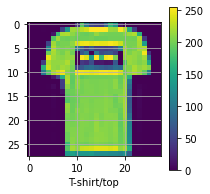

In [22]:
plt.figure(figsize=(3,3))
# 要展示的图片
plt.imshow(train_images[1])
plt.xlabel(class_names[train_labels[1]])
# 颜色条
plt.colorbar()
# 是否显示网格
plt.grid(True)
# 展示
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对训练集和测试集进行预处理：

In [23]:
train_images = train_images / 255.0
test_images = test_images / 255.0

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示训练集中的前 25 个图像，并在每个图像下方显示类名称。

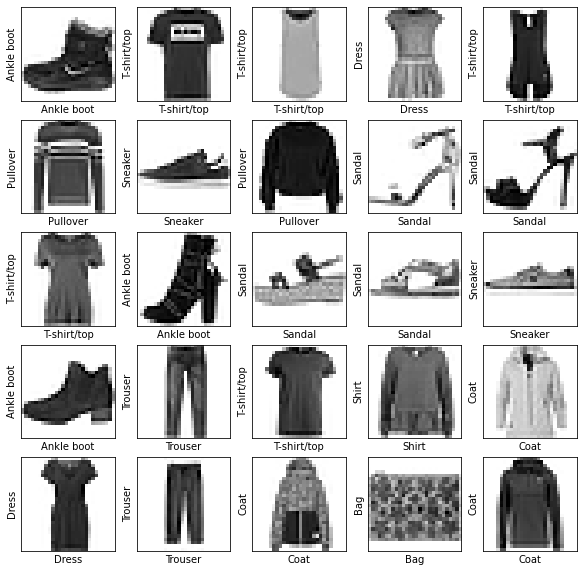

In [24]:
# figure() 函数会产生一个指定编号为 num 的图：
# figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True)
# figsize:指定figure(图形)的宽和高，单位为英寸；
plt.figure(figsize=(10,10))
for i in range(25):
    # 创建单个子图,5X5的矩阵
    plt.subplot(5,5,i+1)
    # 设置横轴记号
    plt.xticks([])
    # 设置纵轴记号
    plt.yticks([])
    # 是否显示网格
    plt.grid(False)
    # 展示指定位置的图片,并指定展示的颜色类型
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    # 添加X轴标签
    plt.xlabel(class_names[train_labels[i]])
    # 添加轴标签
    plt.ylabel(class_names[train_labels[i]])
    
plt.show()

## 构建模型
构建神经网络需要先配置模型的层，然后再编译模型。

### 设置层
神经网络的基本组成部分是层。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。
大多数深度学习都包括将简单的层链接在一起。大多数层（如 tf.keras.layers.Dense）都具有在训练期间才会学习的参数。


In [40]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28,28)),
#     keras.layers.Dense(128,activation='relu'),
#     keras.layers.Dense(10)
# ])

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(10))

该网络的第一层 tf.keras.layers.Flatten 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 tf.keras.layers.Dense 层的序列。它们是密集连接或全连接神经层。第一个 Dense 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

## 编译模型
在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：
- 损失函数 - 用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。
- 优化器 - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标 - 用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [13]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
   metrics=['accuracy']
)

## 训练模型
训练神经网络模型需要执行以下步骤：
- 将训练数据馈送给模型。在本例中，训练数据位于 train_images 和 train_labels 数组中。
- 模型学习将图像和标签关联起来。
- 要求模型对测试集（在本例中为 test_images 数组）进行预测。
- 验证预测是否与 test_labels 数组中的标签相匹配。

### 向模型馈送数据
要开始训练，请调用 model.fit 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 739us/step - loss: 0.6210 - accuracy: 0.7844
Epoch 2/10
1875/1875 [==============================] - 1s 707us/step - loss: 0.3829 - accuracy: 0.8603
Epoch 3/10
1875/1875 [==============================] - 1s 684us/step - loss: 0.3449 - accuracy: 0.8745
Epoch 4/10
1875/1875 [==============================] - 1s 667us/step - loss: 0.3128 - accuracy: 0.8851
Epoch 5/10
1875/1875 [==============================] - 1s 669us/step - loss: 0.3002 - accuracy: 0.8883
Epoch 6/10
1875/1875 [==============================] - 1s 678us/step - loss: 0.2774 - accuracy: 0.8975
Epoch 7/10
1875/1875 [==============================] - 1s 674us/step - loss: 0.2572 - accuracy: 0.9059
Epoch 8/10
1875/1875 [==============================] - 1s 685us/step - loss: 0.2512 - accuracy: 0.9070
Epoch 9/10
1875/1875 [==============================] - 1s 708us/step - loss: 0.2421 - accuracy: 0.9096
Epoch 10/10
1875/1875 [==============================] - 1s 707u

在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

### 评估准确率
接下来，比较模型在测试数据集上的表现：

In [18]:
test_loss,test_acc = model.evaluate(test_images,test_labels,verbose=2)

print('\nTtest acccccuracy:',test_acc)

313/313 - 0s - loss: 0.3284 - accuracy: 0.8879

Ttest acccccuracy: 0.8878999948501587


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表过拟合。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。

### 进行预测
在模型经过训练后，您可以使用它对一些图像进行预测。模型具有线性输出，即 logits。您可以附加一个 softmax 层，将 logits 转换成更容易理解的概率。

In [20]:
probability_model = tf.keras.Sequential(
    [model,tf.keras.layers.Softmax()]
)

predictions = probability_model.predict(test_images)

在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [21]:
predictions[0]

array([1.1952950e-06, 1.3733313e-08, 7.8122739e-08, 7.0495943e-08,
       3.8537305e-06, 2.4738604e-02, 1.8692017e-05, 2.8435927e-02,
       8.4217174e-07, 9.4680071e-01], dtype=float32)

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。您可以看到哪个标签的置信度值最大：

In [22]:
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 class_names[9]。通过检查测试标签发现这个分类是正确的：

您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [57]:
def plot_image(i,predictions_array,true_label,img):
    predictions_array,true_label,img = predictions_array,true_label[i],img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img,cmap = plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color
              )

def plot_value_array(i,predictions_array,true_label):
    predictions_array,true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10),predictions_array,color = "#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### 验证预测结果
在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

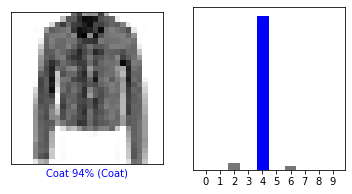

In [61]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

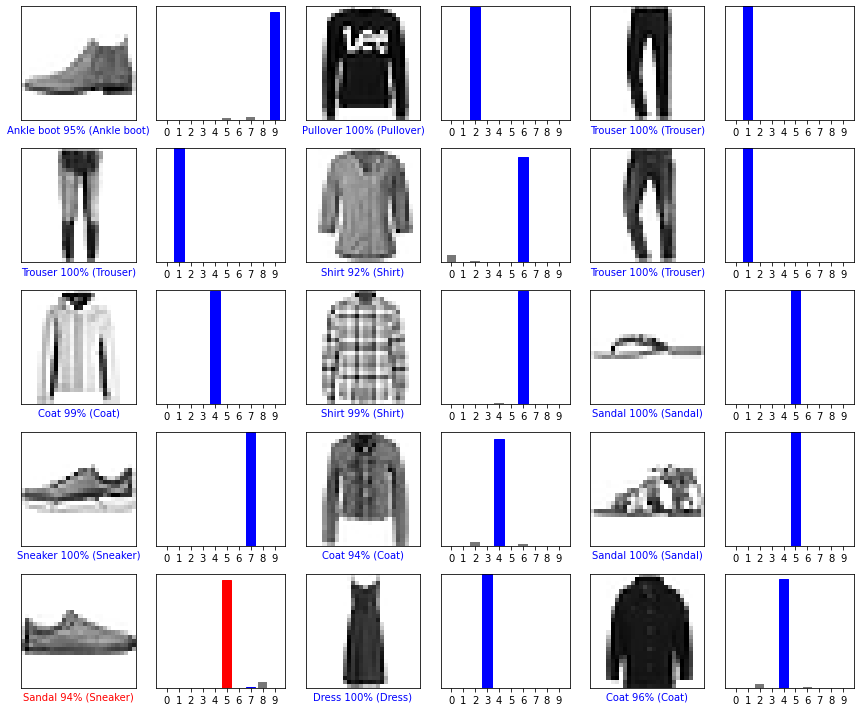

In [62]:
# Plot the first X test images, their predicted labels, and the true labels.
# 绘制第一个X测试图像，他们的预测标签，和真实标签。
# Color correct predictions in blue and incorrect predictions in red.
# 用蓝色标出正确的预测，用红色标出错误的预测。
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 使用训练好的模型
最后，使用训练好的模型对单个图像进行预测。

In [63]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


tf.keras 模型经过了优化，可同时对一个批或一组样本进行预测。因此，即便您只使用一个图像，您也需要将其添加到列表中：

In [64]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


现在预测这个图像的正确标签：

In [66]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[4.9066532e-04 5.4739843e-14 9.9797434e-01 1.3110824e-07 1.1858620e-03
  4.3496027e-12 3.4910475e-04 9.5374248e-16 6.3331362e-09 8.4454603e-18]]


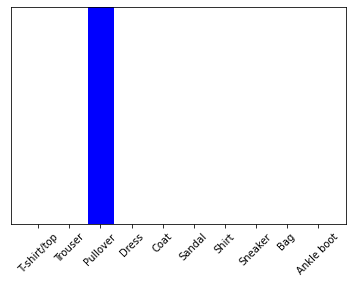

In [70]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

keras.Model.predict 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [72]:
np.argmax(predictions_single[0])

2

该模型会按照预期预测标签。